In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.sparse
import matplotlib.pylab as plt

from pyinverse.axis import RegularAxis
from pyinverse.grid import RegularGrid
from pyinverse.rect import srect_2D_proj, srect_2D_proj_ramp
from pyinverse.fbp import fbp
from pyinverse.radon import radon_matrix

In [3]:
# Nx = 128
# Ny = 128
# Na = 201
# Np = 1001

# Nx = 301
# Ny = 311
# Na = 401
# Np = 501

Nx = 64
Ny = 73
Na = 100
Np = 81

#Nx = 64
#Ny = 64
#Na = 64
#Np = 64

#Nx = 32
#Ny = 32
#Na = 100
#Np = 81

In [4]:
axis_x = RegularAxis.linspace(-1, 1, Nx)
axis_y = RegularAxis.linspace(-1, 1, Ny)
#axis_t = RegularAxis.linspace(-1, 1, Np)
# axis_t = RegularAxis.linspace(-np.sqrt(2), np.sqrt(2), Np)
axis_t = RegularAxis.linspace(-3, 3, Np)  # the bounds of the t axis must be large enough to avoid divergence from theory
# axis_t = RegularAxis.linspace(-10, 10, Np)  # the bounds of the t axis must be large enough to avoid divergence from theory
axis_theta = RegularAxis.linspace(0, 180, Na, endpoint=False)

In [5]:
grid = RegularGrid(axis_x, axis_y)
grid_y = RegularGrid(axis_theta, axis_t)

In [6]:
X = np.zeros((Ny, Nx))
X[(np.abs(grid.centers[0]) <= 0.5) & (np.abs(grid.centers[1]) <= 0.5)] = 1

<IPython.core.display.Javascript object>


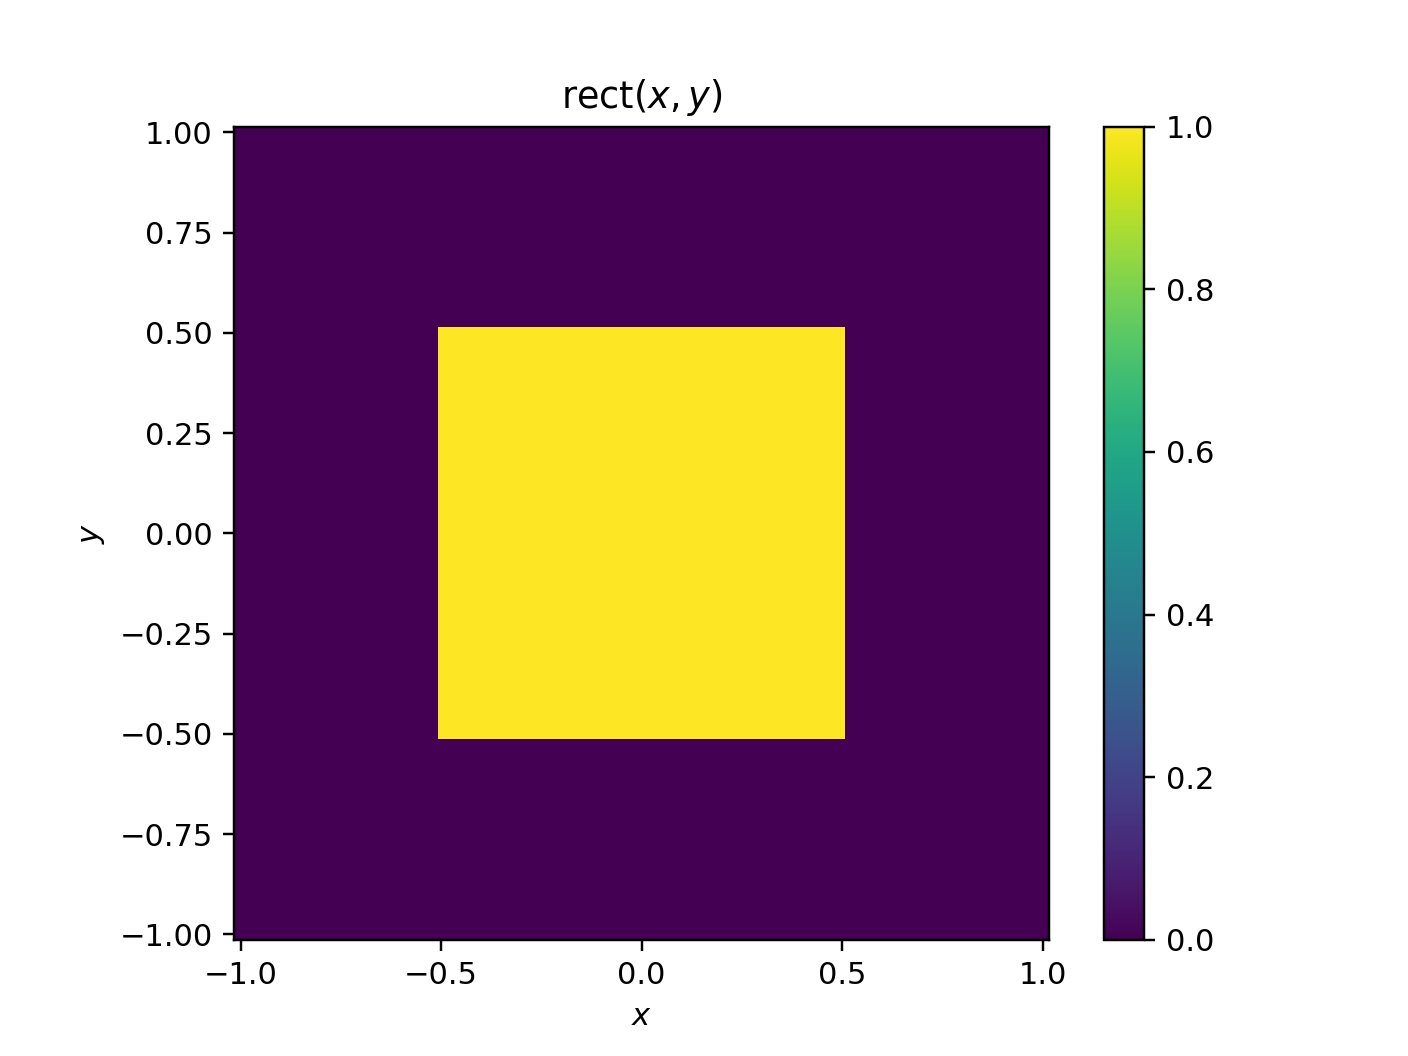

In [7]:
fig, ax = plt.subplots()
im = grid.plot(ax, X)
ax.set_title('rect$(x, y)$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
fig.colorbar(im);

In [8]:
theta_k_deg = 22.125
theta_k_rad = np.radians(theta_k_deg)

In [9]:
p_theta_theory = srect_2D_proj([theta_k_rad], axis_t.centers, 1, 1)

<IPython.core.display.Javascript object>


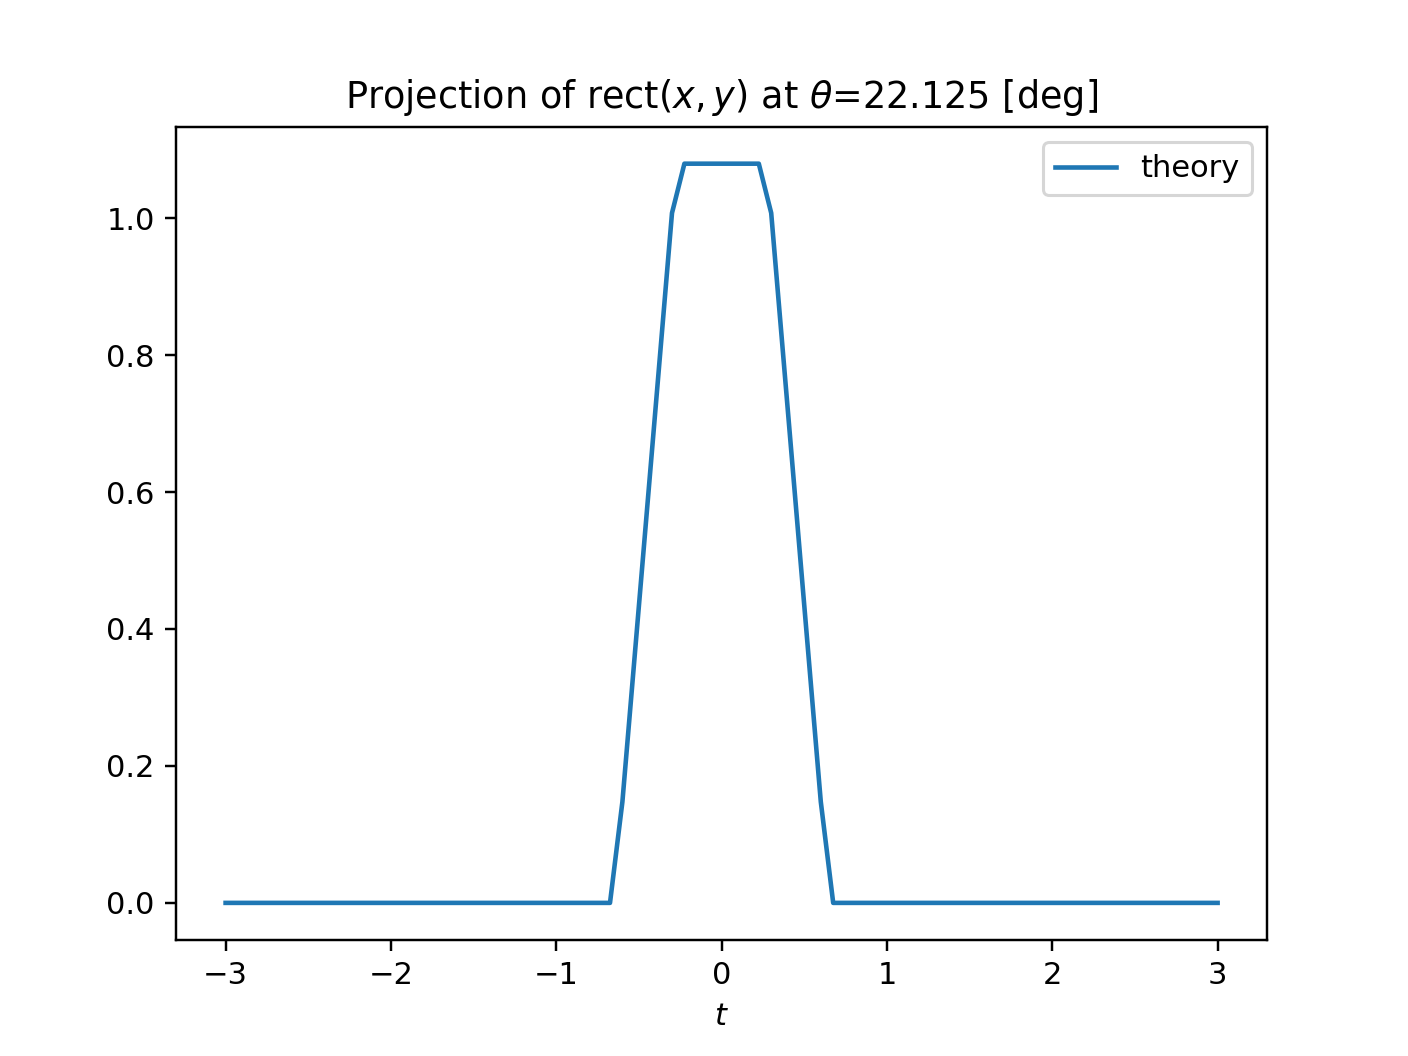

In [10]:
fig, ax = plt.subplots()
ax.plot(axis_t.centers, p_theta_theory, label='theory')
ax.legend()
ax.set_title(f'Projection of rect$(x, y)$ at $\\theta$={theta_k_deg:.3f} [deg]')
ax.set_xlabel(r'$t$');

In [11]:
axis_omega_t, P_theta_theory_fft = axis_t.spectrum(p_theta_theory.flat, real=True)

In [12]:
assert np.allclose(np.imag(P_theta_theory_fft), 0)
P_theta_theory_fft = np.real(P_theta_theory_fft)

In [13]:
upsilon_Hz = axis_omega_t.Hz().centers
P_theta_theory = np.sinc(upsilon_Hz * np.cos(theta_k_rad)) * np.sinc(upsilon_Hz * np.sin(theta_k_rad))

<IPython.core.display.Javascript object>


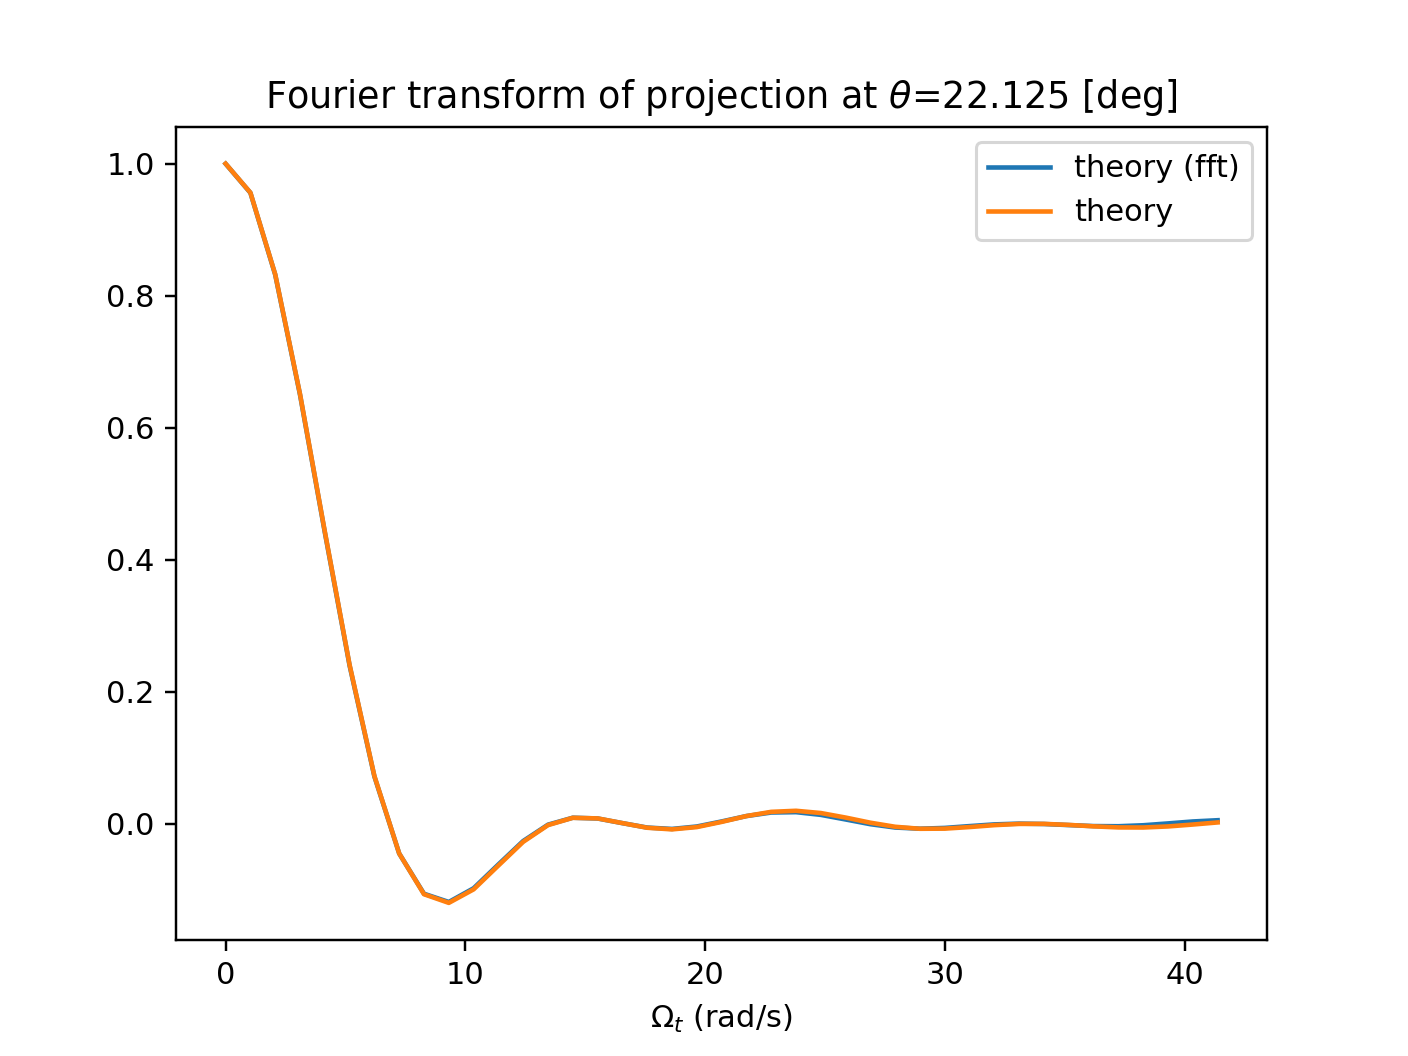

In [14]:
fig, ax = plt.subplots()
ax.plot(axis_omega_t.centers, P_theta_theory_fft, label='theory (fft)')
ax.plot(axis_omega_t.centers, P_theta_theory, label='theory')
ax.legend()
ax.set_xlabel(r'$\Omega_t$ (rad/s)')
ax.set_title(f'Fourier transform of projection at $\\theta$={theta_k_deg:.3f} [deg]');

<IPython.core.display.Javascript object>


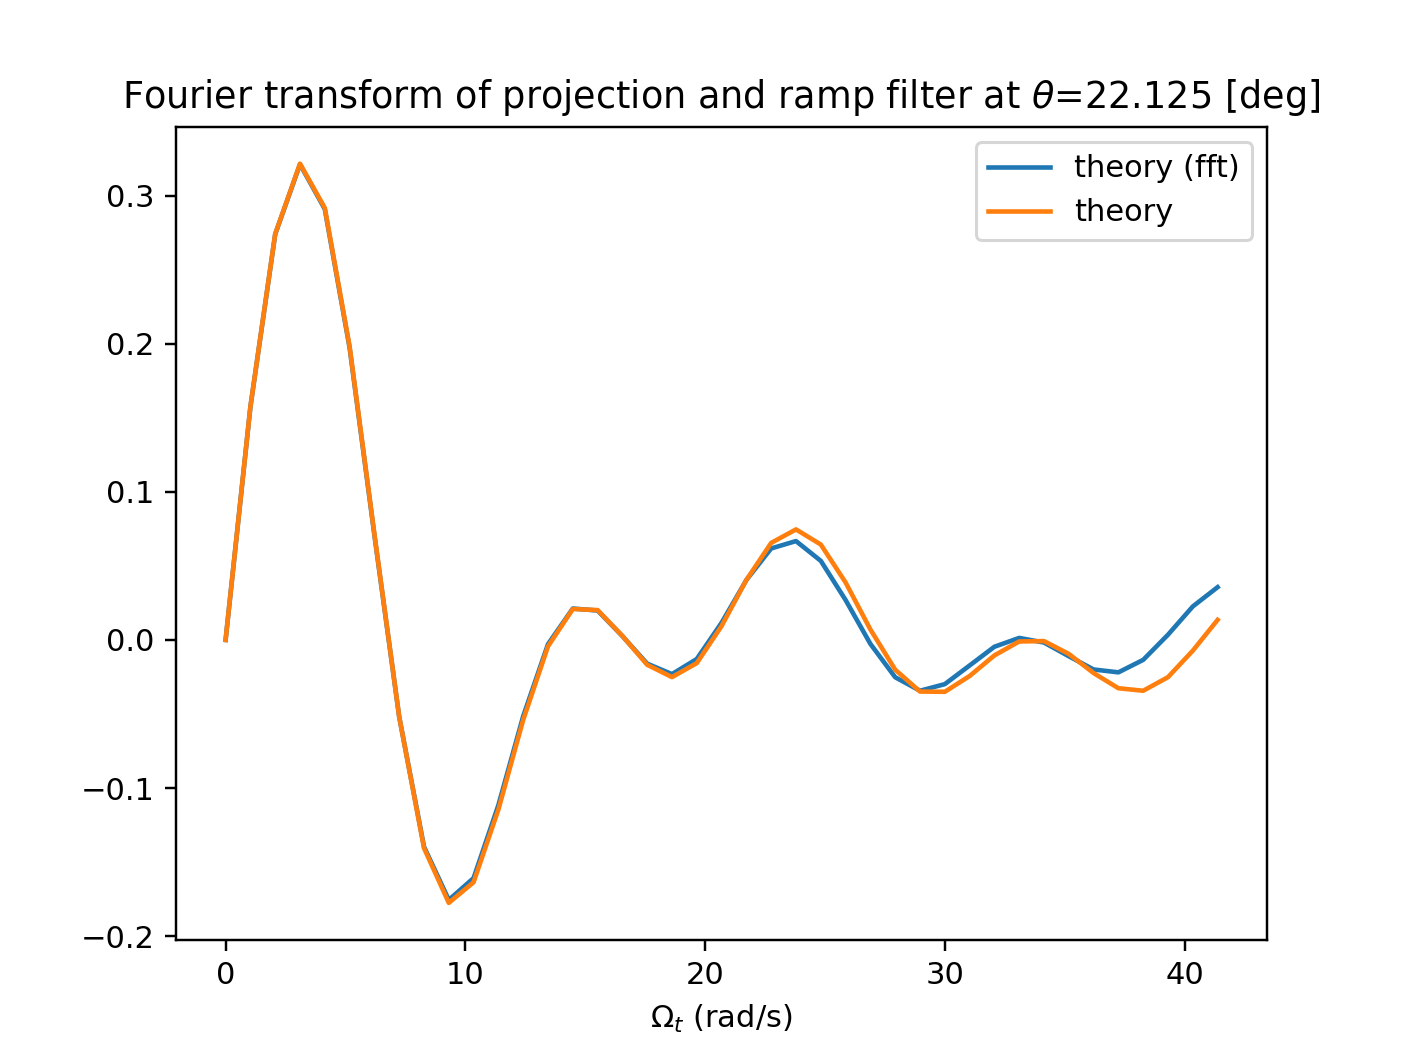

In [15]:
fig, ax = plt.subplots()
ax.plot(axis_omega_t.centers, np.abs(upsilon_Hz) * P_theta_theory_fft, label='theory (fft)')
ax.plot(axis_omega_t.centers, np.abs(upsilon_Hz) * P_theta_theory, label='theory')
ax.legend()
ax.set_xlabel(r'$\Omega_t$ (rad/s)')
ax.set_title(f'Fourier transform of projection and ramp filter at $\\theta$={theta_k_deg:.3f} [deg]');

In [16]:
_, p_theta_ramp_ifft = axis_omega_t.ispectrum(P_theta_theory * np.abs(upsilon_Hz))

<IPython.core.display.Javascript object>


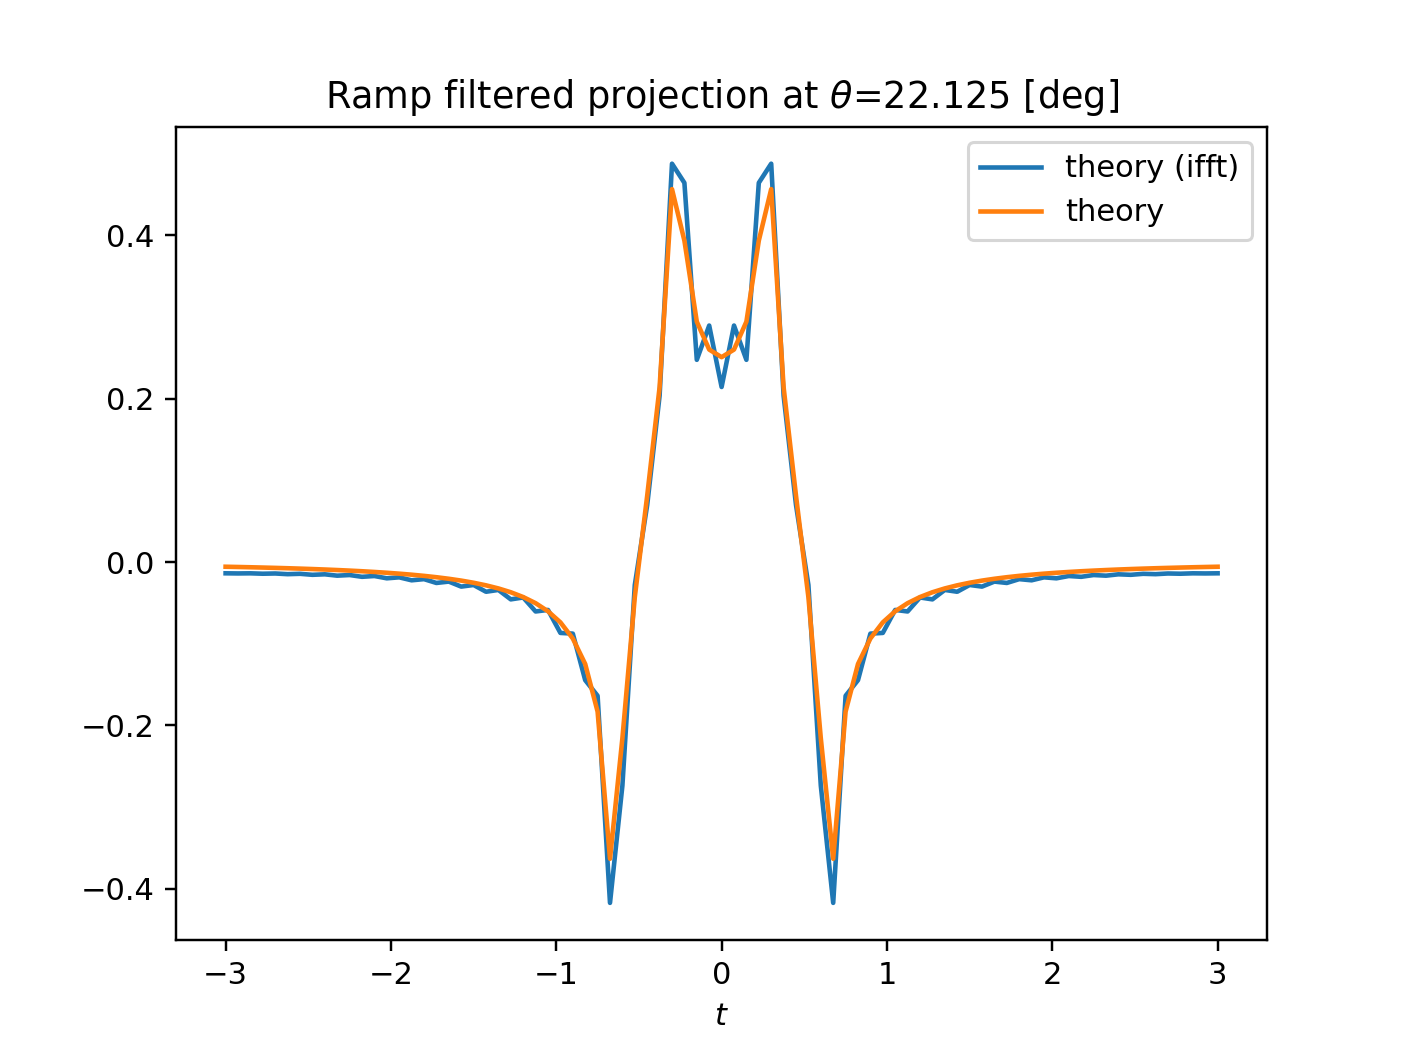

In [17]:
fig, ax = plt.subplots()
ax.plot(axis_t.centers, p_theta_ramp_ifft, label='theory (ifft)')
ax.plot(axis_t.centers, srect_2D_proj_ramp([theta_k_rad], axis_t.centers, 1, 1), label='theory')
ax.legend()
ax.set_xlabel(r'$t$')
ax.set_title(f'Ramp filtered projection at $\\theta$={theta_k_deg:.3f} [deg]');

In [18]:
p_theory = srect_2D_proj(np.radians(axis_theta.centers), axis_t.centers, 1, 1)

<IPython.core.display.Javascript object>


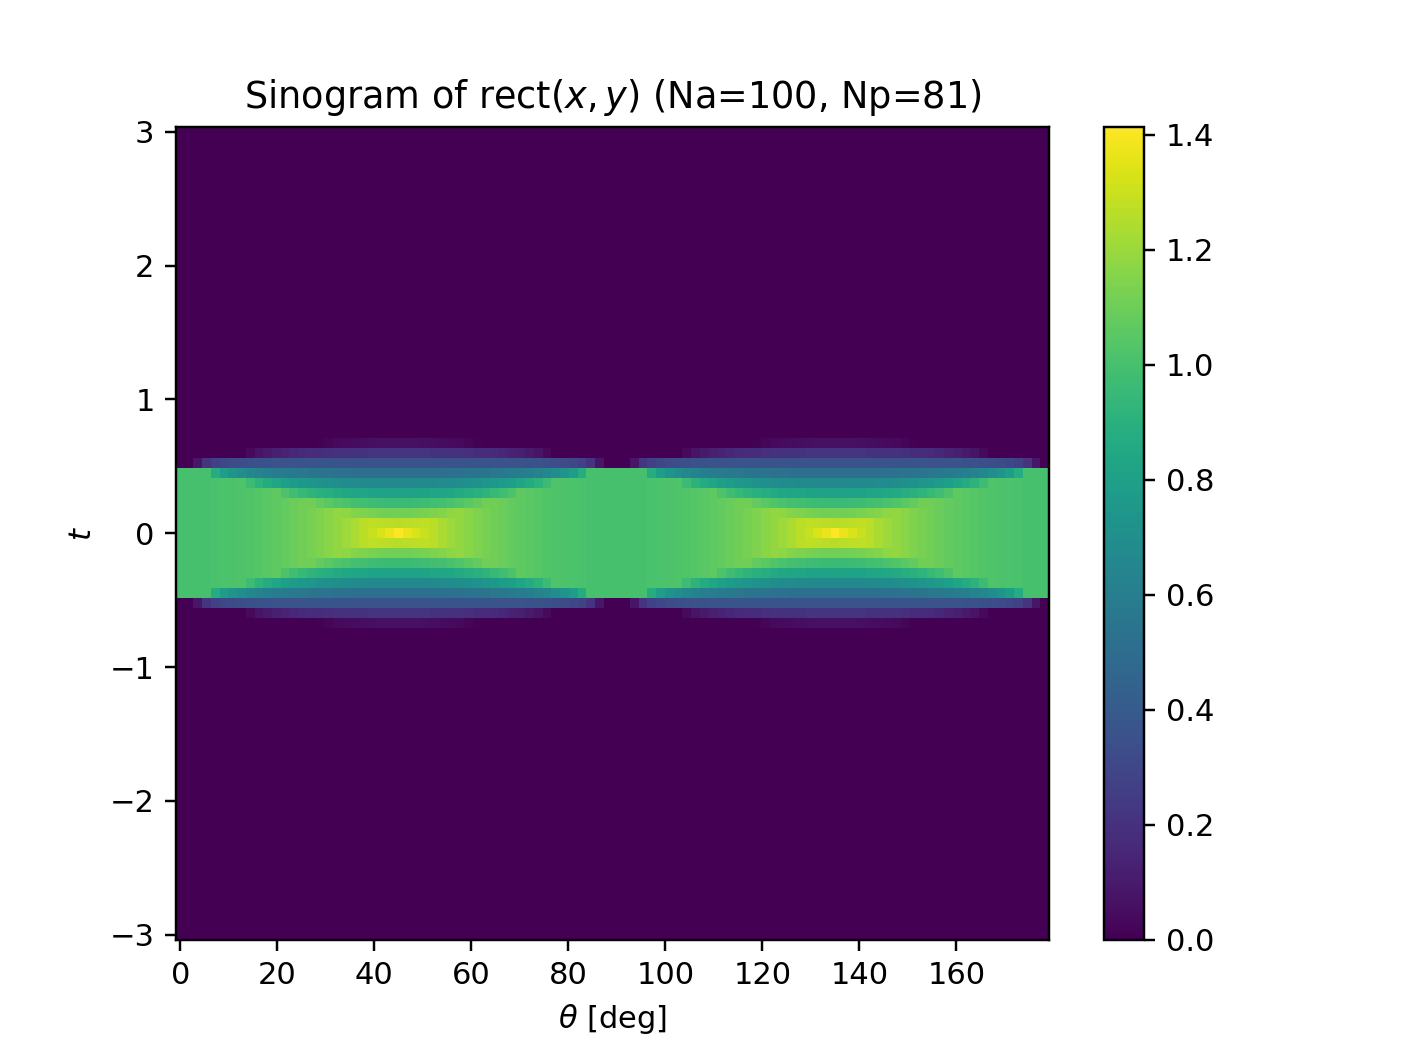

In [19]:
fig, ax = plt.subplots()
im = grid_y.plot(ax, p_theory, aspect='auto')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$t$')
ax.set_title(f'Sinogram of rect$(x, y)$ (Na={Na}, Np={Np})')
fig.colorbar(im);

In [20]:
grid_y_omega0, P_theory = grid_y.spectrum(p_theory, real=True, axis=0)

In [21]:
W = np.abs(grid_y_omega0.axis_y.Hz().centers)  # W(f) = |f|

In [22]:
_, p_ramp = grid_y_omega0.ispectrum(np.atleast_2d(W).T * P_theory, axis=0)

<IPython.core.display.Javascript object>


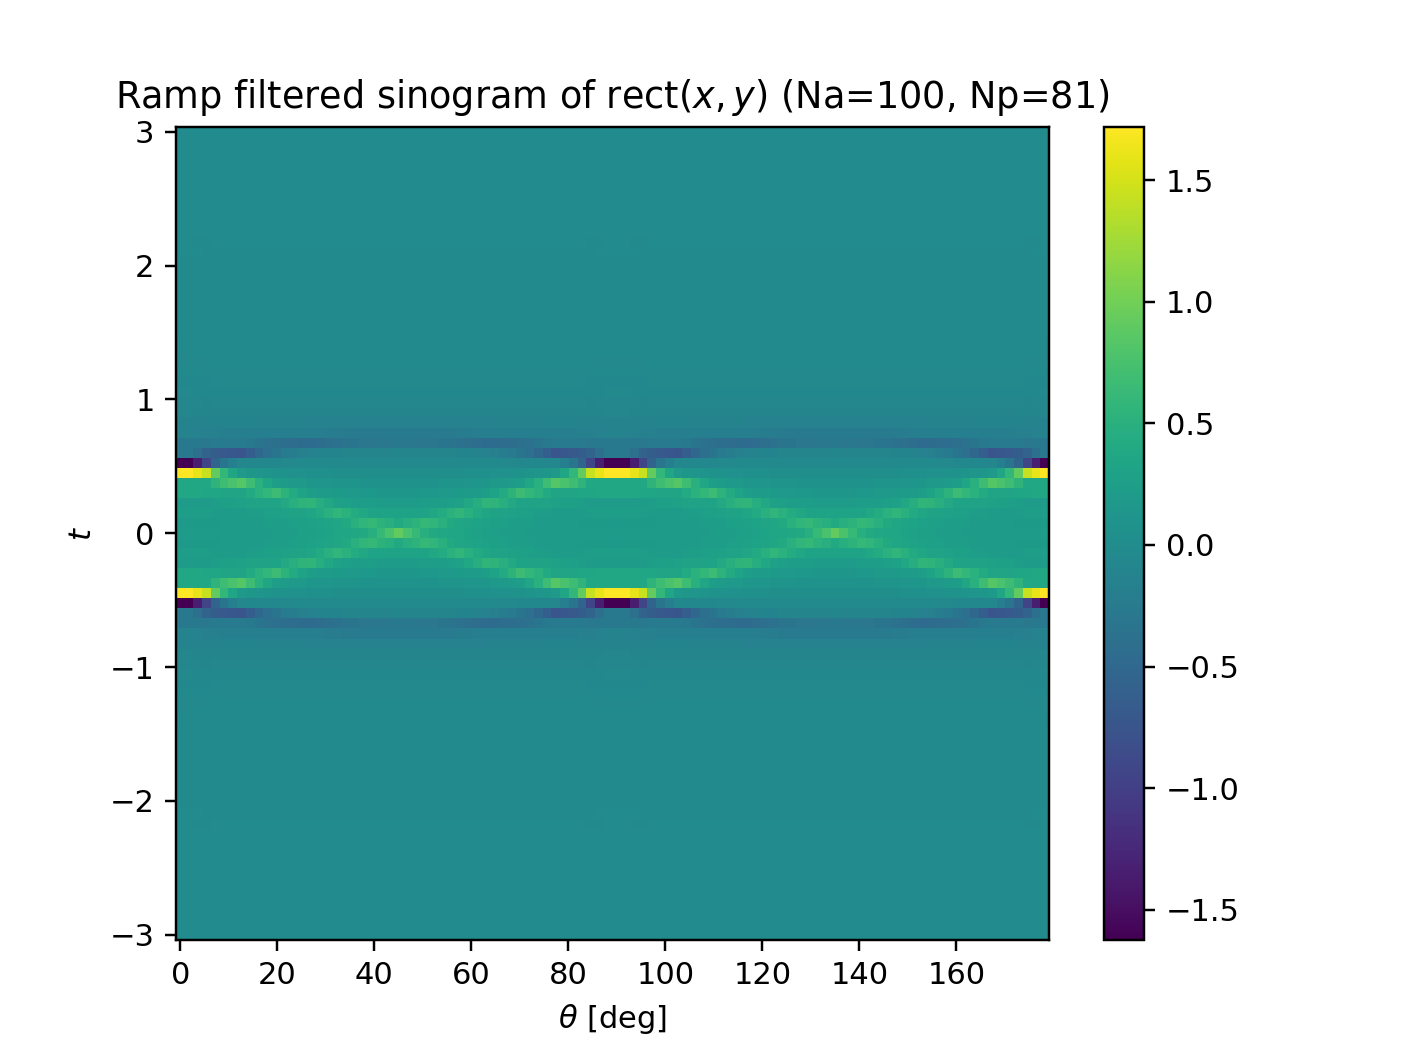

In [23]:
fig, ax = plt.subplots()
im = grid_y.plot(ax, p_ramp, aspect='auto')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$t$')
ax.set_title(f'Ramp filtered sinogram of rect$(x, y)$ (Na={Na}, Np={Np})')
fig.colorbar(im);

In [24]:
meshgrid_X, meshgrid_Y = np.meshgrid(axis_x.centers, axis_y.centers)

In [25]:
S = np.zeros((Ny, Nx))
for k, theta_k in enumerate(np.radians(axis_theta.centers)):
    t_theta_k = meshgrid_X * np.cos(theta_k) + meshgrid_Y * np.sin(theta_k)
    S_xy_interp = np.interp(t_theta_k.flat, axis_t.centers, p_ramp[:, k], left=np.nan, right=np.nan)
    S_xy_interp.shape = S.shape
    S += S_xy_interp
S *= np.radians(axis_theta.T)

<IPython.core.display.Javascript object>


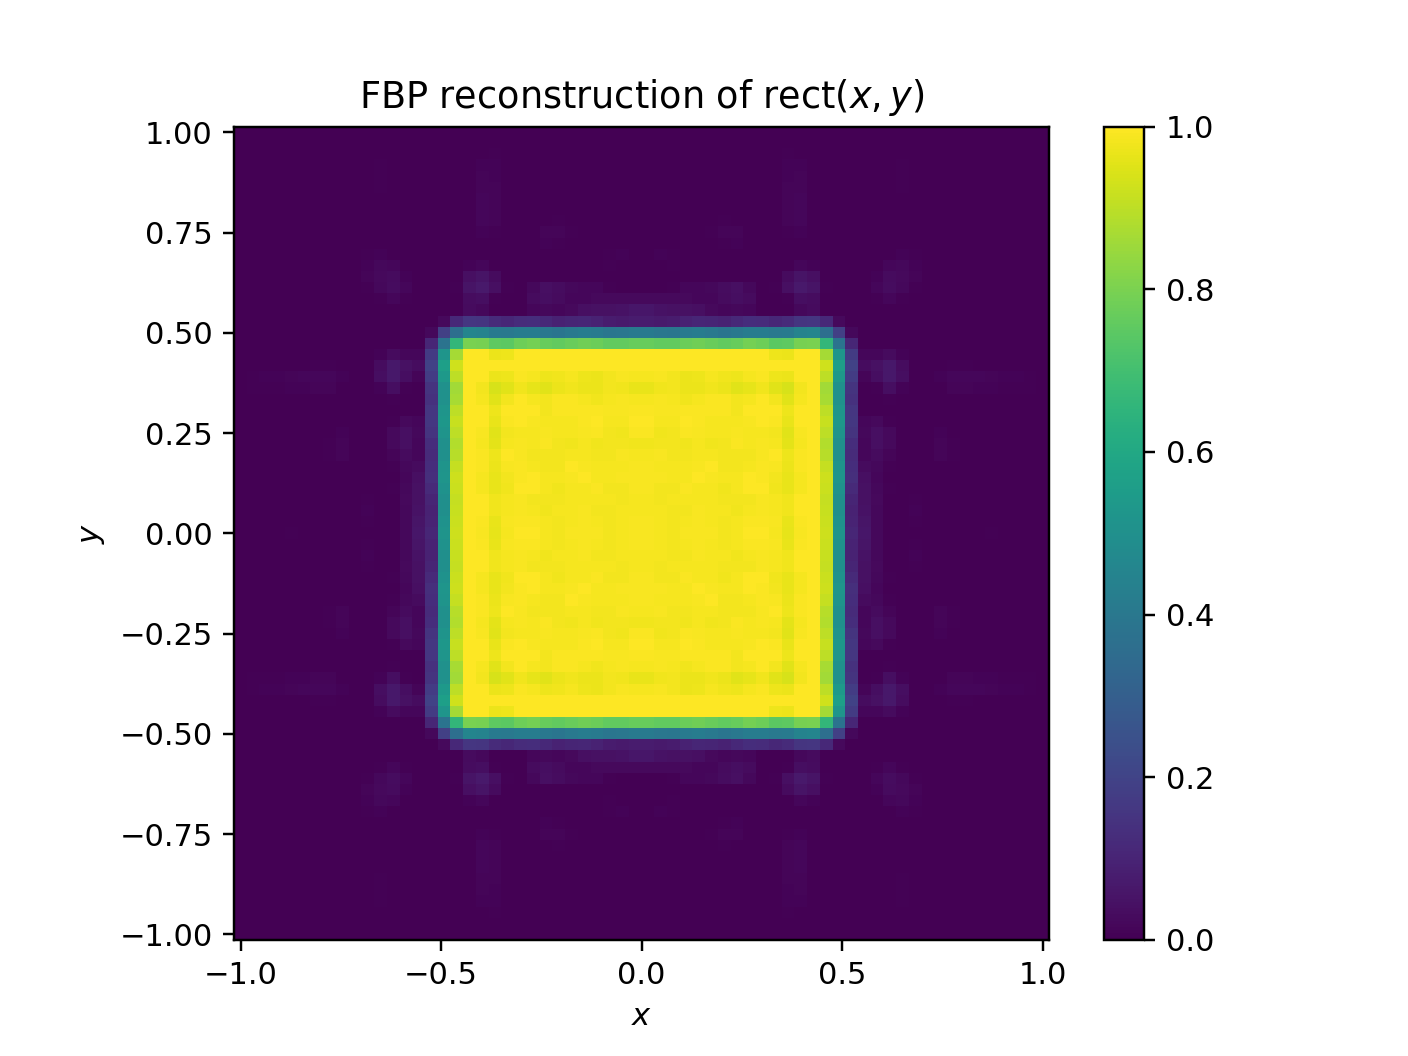

In [26]:
fig, ax = plt.subplots()
im = grid.plot(ax, S, vmin=0, vmax=1)
fig.colorbar(im)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r'FBP reconstruction of rect$(x, y)$');

In [27]:
p_hat = fbp(grid, grid_y, p_theory)

100%|█████████████████████████████████████████████████████████████████| 73/73 [00:23<00:00,  3.09it/s]


<IPython.core.display.Javascript object>


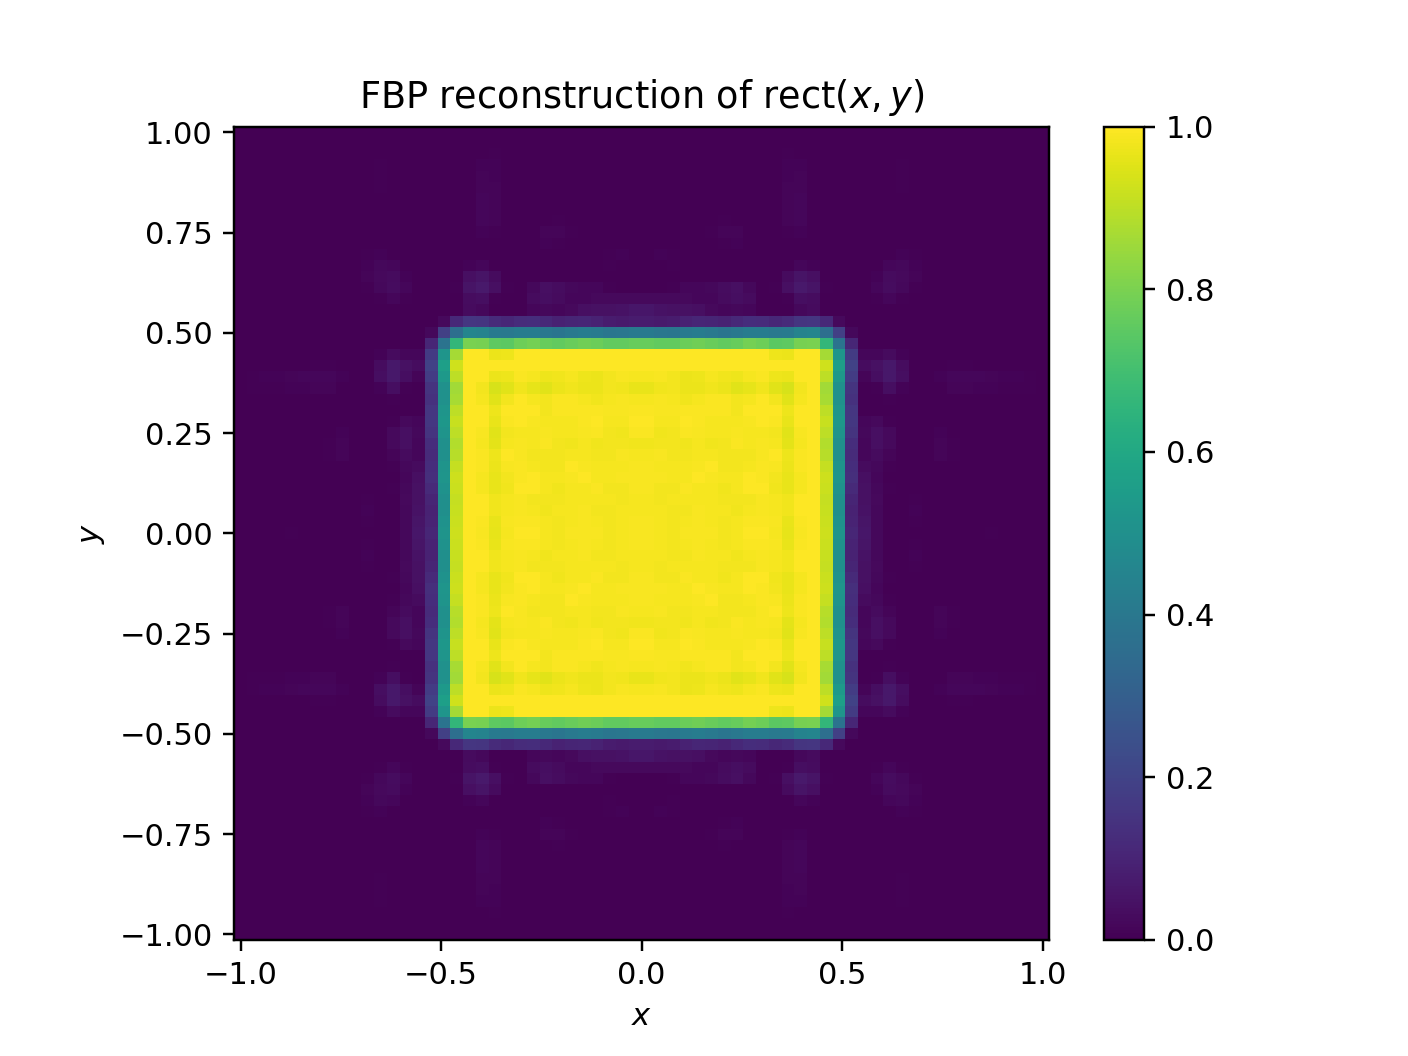

In [28]:
fig, ax = plt.subplots()
im = grid.plot(ax, p_hat, vmin=0, vmax=1)
fig.colorbar(im)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r'FBP reconstruction of rect$(x, y)$');

In [29]:
#R = radon_matrix(grid, grid_y)
R = radon_matrix(grid, grid_y, a=1/grid_y.axis_y.T)

100%|█████████████████████████████████████████████████████████████████| 73/73 [01:42<00:00,  1.40s/it]


In [30]:
p_matrix = R.todense() @ X.flat
p_matrix.shape = grid_y.shape

<IPython.core.display.Javascript object>


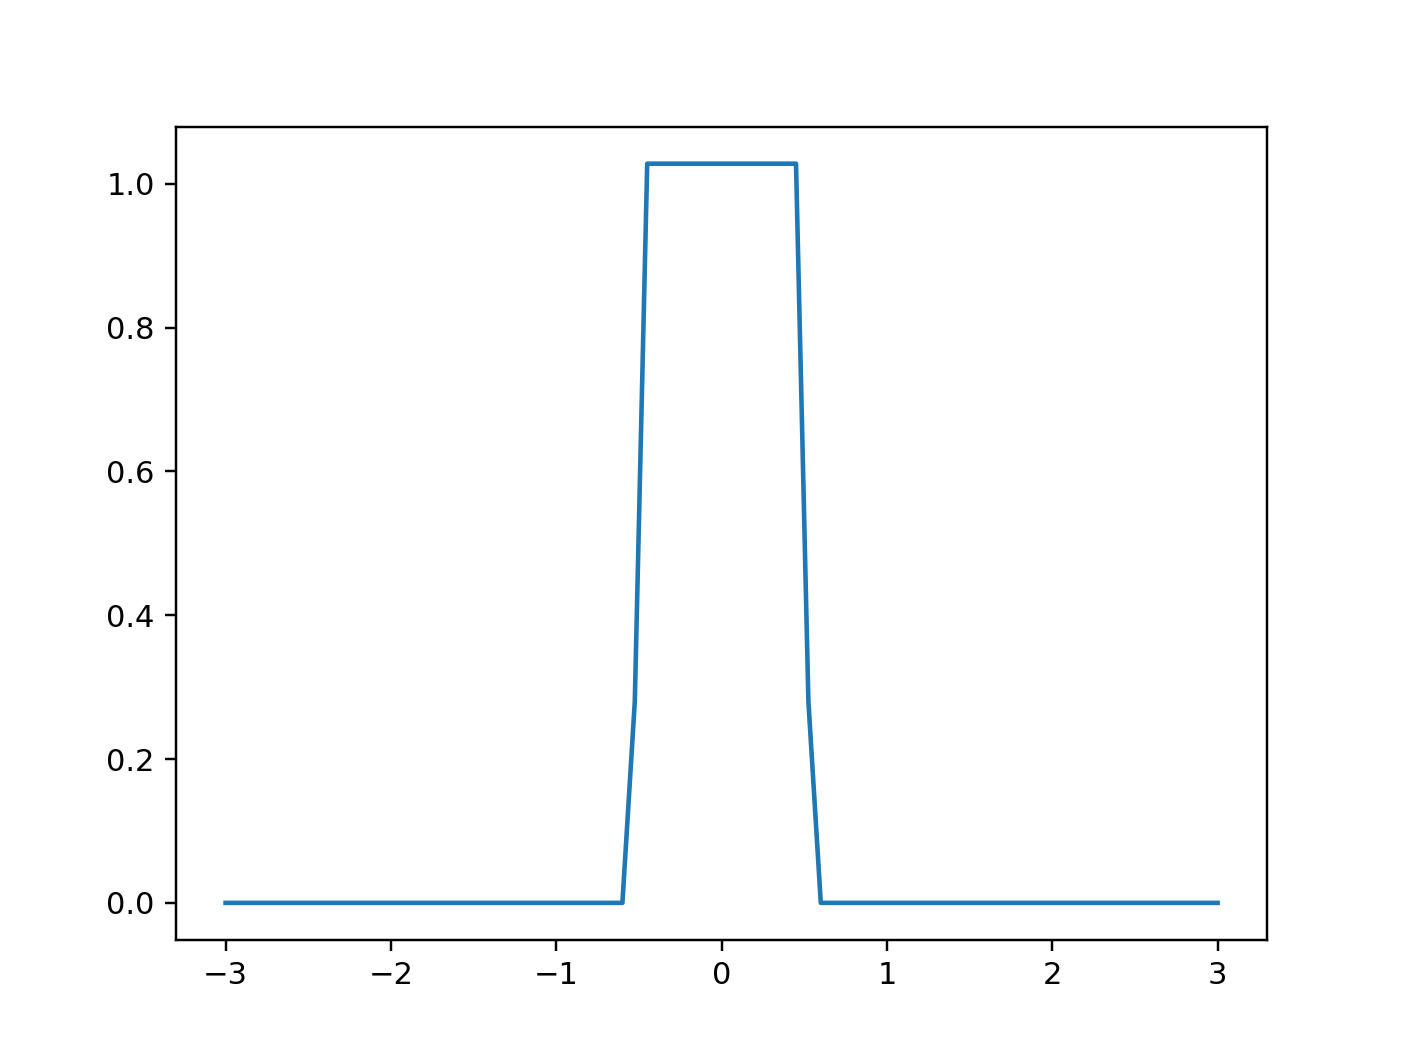

In [31]:
fig, ax = plt.subplots()
ax.plot(grid_y.axis_y.centers, p_matrix[:, 0])

<IPython.core.display.Javascript object>


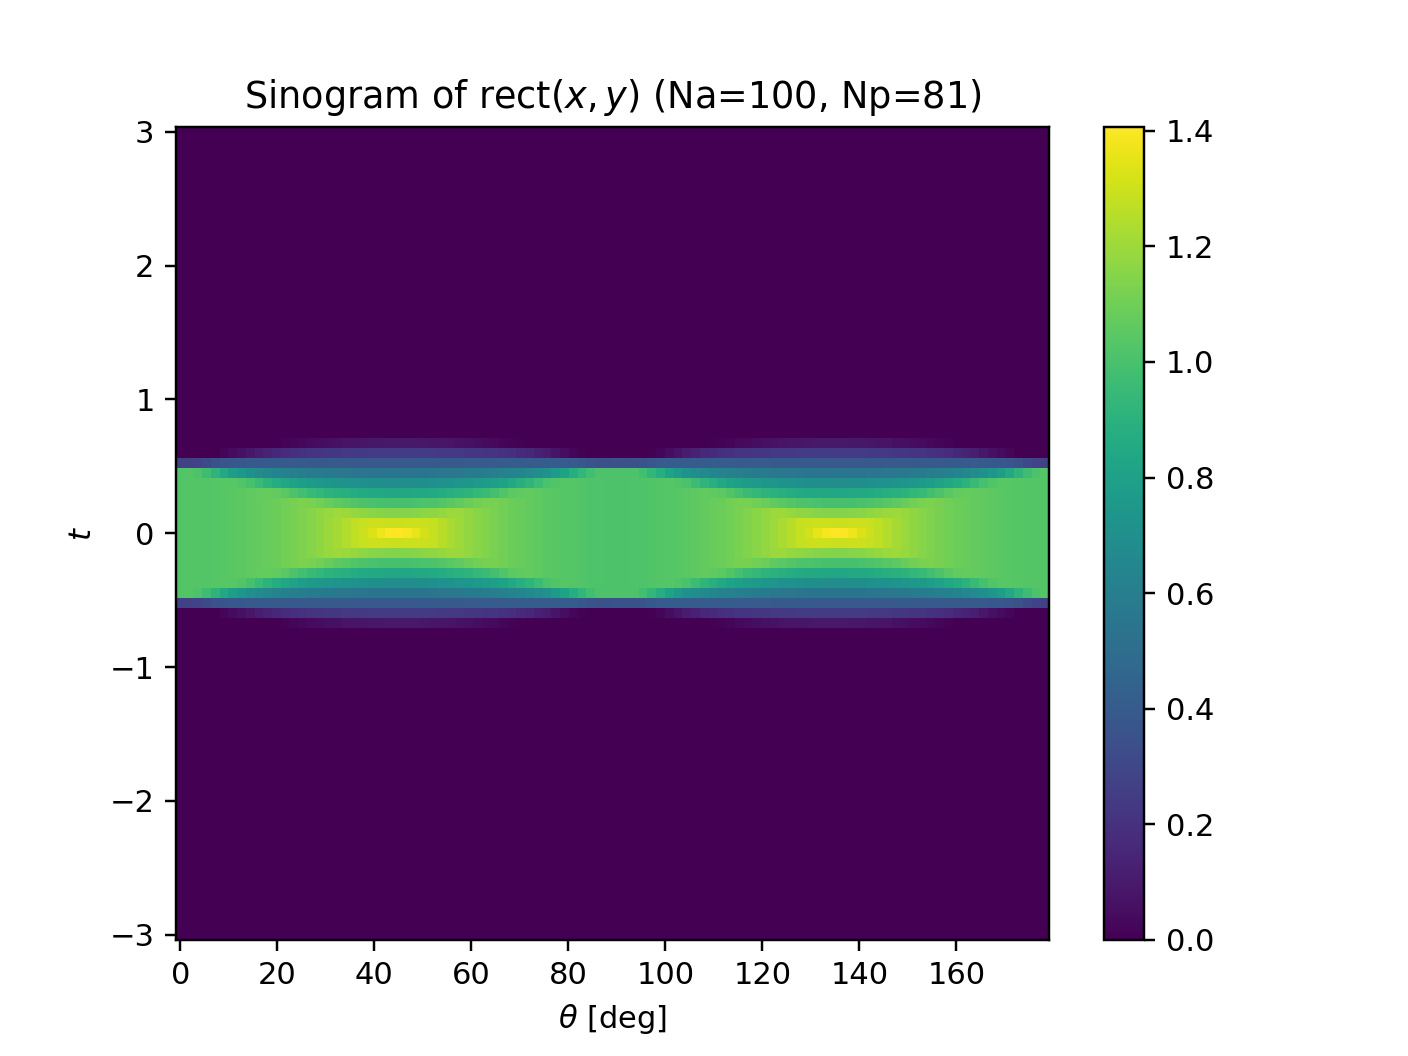

In [32]:
fig, ax = plt.subplots()
im = grid_y.plot(ax, p_matrix, aspect='auto')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$t$')
ax.set_title(f'Sinogram of rect$(x, y)$ (Na={Na}, Np={Np})')
fig.colorbar(im);

In [33]:
p_hat2 = fbp(grid, grid_y, p_theory, radon_matrix=R)

<IPython.core.display.Javascript object>


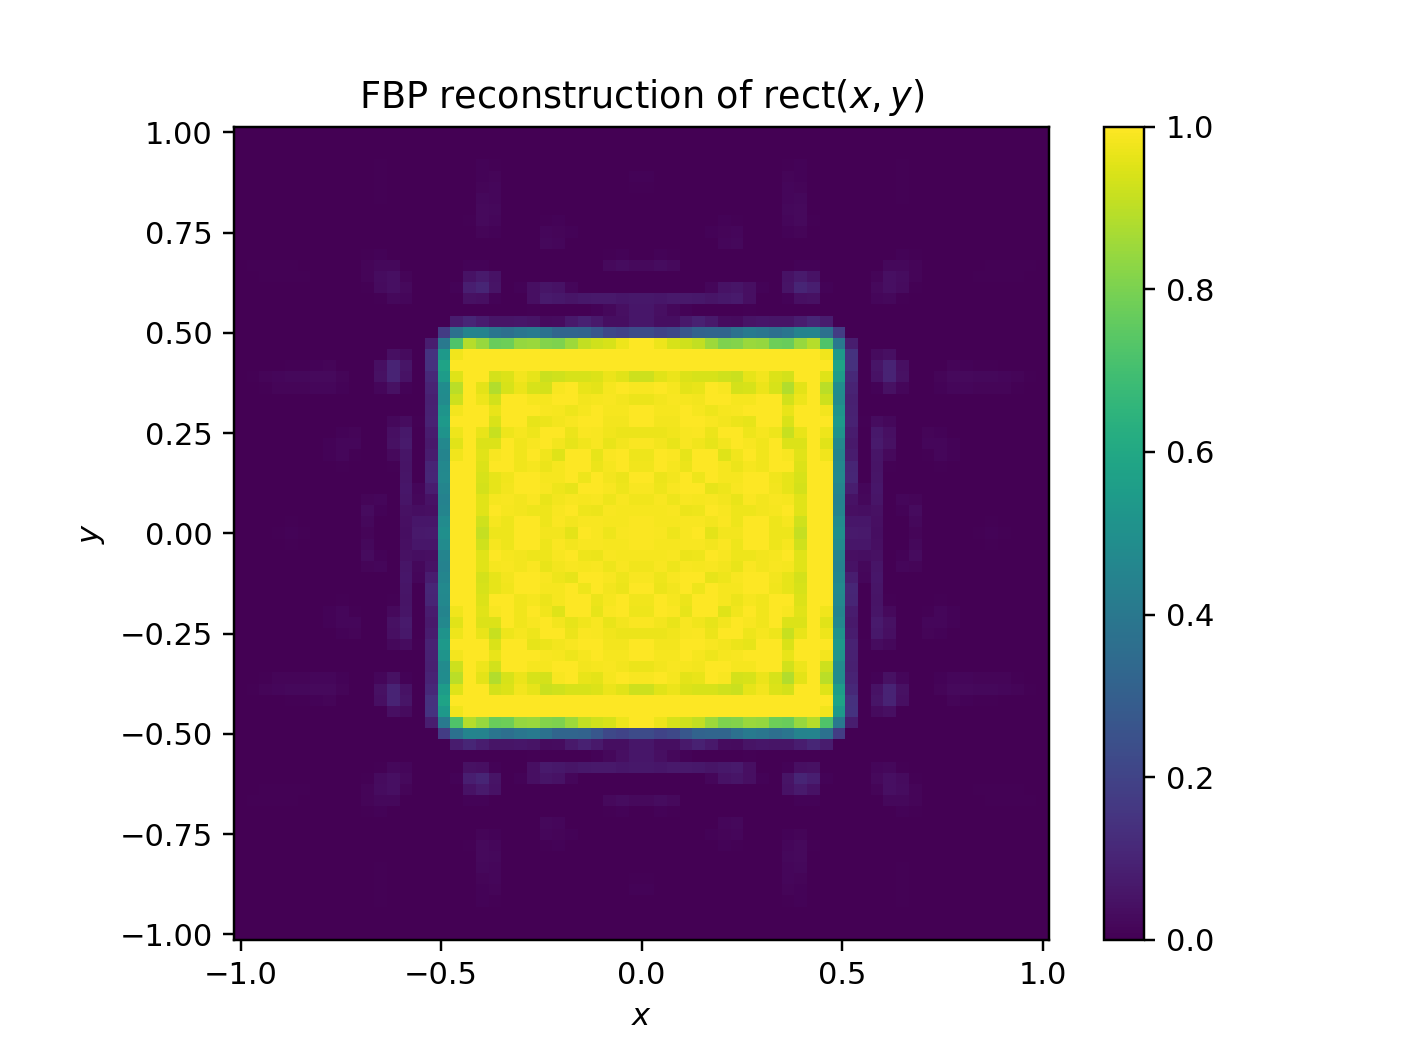

In [34]:
fig, ax = plt.subplots()
im = grid.plot(ax, p_hat2, vmin=0, vmax=1)
fig.colorbar(im)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r'FBP reconstruction of rect$(x, y)$');